In [1]:
import pickle
import pandas as pd
import os, glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#!pip install pyscenic
#!pip install --upgrade pyarrow==0.16.0

# Environment Setup
Before running the notebook you may need to create a dedicated conda environment running:

+ `conda create -y -n pyscenic python=3.7`
+ `conda activate pyscenic  `
+ `conda install -y numpy`
+ `conda install -y -c anaconda cytoolz`
+ `pip install pyscenic==0.11.1`
+ `pip install grenadine   `
+ `pip install jupyter`
+ `pip install seaborn`

# Load the dataset
Please download the following [scRNA-Seq dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361) from the GEO (3005 single cell transcriptomes taken from the mouse brain, somatosensory cortex and hippocampal regions).

This dataset is also used in the [pyscnenic fullpipeline tutorial](https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20Full%20pipeline.ipynb).

### Load the datasets
+ Load the $M.~musculus$ gene expression dataset

In [25]:
ex_matrix = pd.read_csv("GSE60361_C1-3005-Expression.txt",index_col=0,sep="\t")

In [26]:
ex_matrix = ex_matrix.groupby(ex_matrix.index).mean()

In [27]:
ex_matrix.head()

1772071015_C02  1772071017_G12  1772071017_A05  1772071014_B06  \
cell_id                                                                         
0610005C13Rik             0.0             0.0             0.0             0.0   
0610007N19Rik             0.0             0.0             0.0             0.0   
0610007P14Rik             3.0             0.0             1.0             0.0   
0610009B22Rik             0.0             1.0             3.0             3.0   
0610009D07Rik             1.0             4.0             2.0             1.0   

               1772067065_H06  1772071017_E02  1772067065_B07  1772067060_B09  \
cell_id                                                                         
0610005C13Rik             0.0             0.0             0.0             0.0   
0610007N19Rik             0.0             0.0             0.0             0.0   
0610007P14Rik             1.0             0.0             4.0             3.0   
0610009B22Rik             0.0             0.0             0.0             0.0   
0610009D07Rik             2.0             1.0             6.0             2.0   

               1772071014_E04  1772071015_D04  ...  1772066110_D12  \
cell_id                                        ...                   
0610005C13Rik             0.0             0.0  ...             0.0   
0610007N19Rik             0.0             0.0  ...             0.0   
0610007P14Rik             0.0             3.0  ...             0.0   
0610009B22Rik             2.0             1.0  ...             0.0   
0610009D07Rik             0.0             2.0  ...             1.0   

               1772071017_A07  1772063071_G10  1772058148_C03  1772063061_D09  \
cell_id                                                                         
0610005C13Rik             0.0             0.0             0.0             0.0   
0610007N19Rik             0.0             0.0             1.0             0.0   
0610007P14Rik             0.0             0.0             0.0             0.0   
0610009B22Rik             0.0             0.0             0.0             0.0   
0610009D07Rik             0.0             0.0             1.0             1.0   

               1772067059_B04  1772066097_D04  1772063068_D01  1772066098_A12  \
cell_id                                                                         
0610005C13Rik             0.0             0.0             0.0             0.0   
0610007N19Rik             6.0             1.0             0.0             1.0   
0610007P14Rik             0.0             0.0             0.0             0.0   
0610009B22Rik             0.0             0.0             0.0             0.0   
0610009D07Rik             2.0             1.0             0.0             1.0   

               1772058148_F03  
cell_id                        
0610005C13Rik             0.0  
0610007N19Rik             0.0  
0610007P14Rik             0.0  
0610009B22Rik             0.0  
0610009D07Rik             0.0  

[5 rows x 3005 columns]

In [6]:
ex_matrix.shape

(19970, 3005)

+ Load the Transcription Factors list for $M.~Musculus$ from the PySCENIC [resources folder](https://github.com/aertslab/pySCENIC/blob/master/resources/mm_mgi_tfs.txt). This file was prepared following this [notebook](https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20List%20of%20Transcription%20Factors.ipynb).


In [3]:
tf = pd.read_csv("mm_mgi_tfs.txt",header=None)[0]

+ Load some $M.~Musculus$ TF motifs [ranking databases](https://resources.aertslab.org/cistarget/), for example you can download:
    + mm9-tss-centered-10kb-10species.mc9nr
    + mm9-500bp-upstream-7species.mc9nr
    + mm9-500bp-upstream-10species.mc9nr
    + mm9-tss-centered-5kb-10species.mc9nr
    + mm9-tss-centered-10kb-7species.mc9nr
    + mm9-tss-centered-5kb-7species.mc9nr

+ For this tutorial we simply download 'mm9-tss-centered-5kb-10species.mc8nr.feather'

In [4]:
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase

In [5]:
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
db_fnames = ["./mm9-tss-centered-5kb-10species.mc8nr.feather"]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]

In [6]:
dbs

[FeatherRankingDatabase(name="mm9-tss-centered-5kb-10species.mc8nr")]

# Preprocessing
Reduce the sc-RNAseq matrix using NMF
+ Choose the number of components

In [13]:
from sklearn.decomposition import NMF
from tqdm.autonotebook import tqdm

/Users/sergiopeignier/anaconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [15]:

components = [10,50,100,150,200,250,300]
error = []
for c in tqdm(components):
    nmf = NMF(c,init="nndsvda")
    nmf.fit_transform(ex_matrix)
    error.append(nmf.reconstruction_err_)

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/sergiopeignier/anaconda3/envs/pyscenic/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Text(0, 0.5, 'Error')

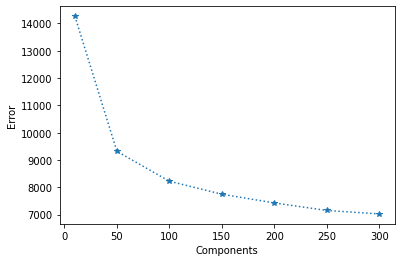

In [16]:
plt.plot(components,error,"*:")
plt.xlabel("Components")
plt.ylabel('Error')

+ Compute the NMF

In [17]:
nmf = NMF(50,init="nndsvda")
X = nmf.fit_transform(ex_matrix)

In [18]:
X = pd.DataFrame(X,index=ex_matrix.index)

In [9]:
X.to_csv("mus_musculus_gene_exp_NMF_50.csv")
#X = pd.read_csv("mus_musculus_gene_exp_NMF_50.csv",index_col=0)
X.head()

0         1         2         3         4         5  \
cell_id                                                                     
0610005C13Rik  0.000000  0.000000  0.000000  0.000000  0.000000  0.006252   
0610007N19Rik  0.000000  0.000000  0.020360  0.000000  0.002518  0.000000   
0610007P14Rik  0.046661  0.026603  0.000000  0.000000  0.057252  0.000000   
0610009B22Rik  0.027337  0.016596  0.000000  0.000000  0.021843  0.026564   
0610009D07Rik  0.000000  0.041498  0.036518  0.094659  0.001850  0.055276   

                      6         7         8         9  ...        40  \
cell_id                                                ...             
0610005C13Rik  0.000000  0.000000  0.000000  0.000000  ...  0.000220   
0610007N19Rik  0.000000  0.000000  0.021151  0.000000  ...  0.000000   
0610007P14Rik  0.000000  0.009508  0.015440  0.002695  ...  0.018358   
0610009B22Rik  0.000000  0.013968  0.015075  0.000000  ...  0.000000   
0610009D07Rik  0.013636  0.000000  0.042606  0.022690  ...  0.017484   

                     41        42        43        44        45        46  \
cell_id                                                                     
0610005C13Rik  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0610007N19Rik  0.037177  0.000000  0.000000  0.020008  0.000000  0.000000   
0610007P14Rik  0.000000  0.375947  0.261929  0.112169  0.000000  0.000000   
0610009B22Rik  0.021407  0.246661  0.091632  0.081423  0.064312  0.178609   
0610009D07Rik  0.000000  0.111176  0.330525  0.315632  0.158365  0.510288   

                     47        48        49  
cell_id                                      
0610005C13Rik  0.000000  0.000000  0.000000  
0610007N19Rik  0.000000  0.000000  0.000000  
0610007P14Rik  0.035383  0.000000  0.050567  
0610009B22Rik  0.000000  0.143425  0.000000  
0610009D07Rik  0.003095  0.000000  0.045152  

[5 rows x 50 columns]

# Infer the GRN
+ Load the score links function and BayesianRidge method

In [19]:
from grenadine.Inference.inference import score_links
from grenadine.Inference.regression_predictors import BayesianRidgeScore

sklearn.linear_model.RandomizedLasso could not be loaded
RandomizedLasso is not available in sklearn 1.0.2


+ Choose the parameters of the underlying BayesianRidge method 

(the parameters are the same as those of [sklearn BayesianRidge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html))

In [20]:
BayesianRidge_params = {"n_iter":30,}

+ Score all the possible edges between Transcription Factors and Target Genes

In [21]:
score_matrix = score_links(gene_expression_matrix=X,
                           score_predictor=BayesianRidgeScore,
                           tf_list=tf, progress_bar=True, **BayesianRidge_params)

  0%|          | 0/19970 [00:00<?, ?it/s]

In [11]:
score_matrix.to_csv("scores_matrix_mus_musculus_BRS_NFM_50.csv")
#score_matrix = pd.read_csv("scores_matrix_mus_musculus_BRS_NFM_50.csv",index_col=0)

In [12]:
score_matrix.head()

1810024B03Rik  2010315B03Rik  2310011J03Rik  2410141K09Rik  \
0610005C13Rik       0.000003       0.000005   8.131983e-08   9.742507e-07   
0610007N19Rik       0.000404       0.000275   2.397724e-04   7.244910e-07   
0610007P14Rik       0.001333       0.001248   1.167562e-03   1.708498e-04   
0610009B22Rik       0.003152       0.001986   2.832657e-03   1.855371e-04   
0610009D07Rik       0.004570       0.001580   1.523583e-03   4.131882e-04   

               2610044O15Rik8  2810403A07Rik  3300002I08Rik  4921501E09Rik  \
0610005C13Rik        0.000078       0.000041       0.000012   3.593663e-07   
0610007N19Rik        0.001002       0.000003       0.000173   1.255392e-04   
0610007P14Rik        0.003733       0.000896       0.002288   1.126803e-04   
0610009B22Rik        0.001002       0.000006       0.003821   2.420020e-04   
0610009D07Rik        0.003456       0.001474       0.000734   3.509967e-04   

               4921509C19Rik  5730507C01Rik  ...       Zscan25   Zscan26  \
0610005C13Rik   4.923439e-08       0.000018  ...  2.748298e-08  0.000021   
0610007N19Rik   2.076779e-05       0.000107  ...  6.786520e-05  0.000011   
0610007P14Rik   3.875124e-04       0.000235  ...  1.261366e-04  0.001206   
0610009B22Rik   5.426033e-04       0.000439  ...  6.395684e-05  0.006388   
0610009D07Rik   5.458703e-04       0.000725  ...  2.486278e-04  0.001665   

                Zscan29       Zscan4b       Zscan4e       Zscan4f    Zswim1  \
0610005C13Rik  0.000011  2.421672e-07  3.585048e-07  1.819544e-07  0.000016   
0610007N19Rik  0.000280  7.653077e-06  9.567294e-06  4.618413e-06  0.000339   
0610007P14Rik  0.001202  8.337227e-06  4.042028e-05  2.439809e-06  0.001143   
0610009B22Rik  0.002291  3.809157e-05  6.491878e-05  4.396220e-05  0.000993   
0610009D07Rik  0.001821  1.367718e-05  1.465535e-05  7.203200e-05  0.001997   

                   Zxdb      Zxdc      Zzz3  
0610005C13Rik  0.000015  0.000012  0.000039  
0610007N19Rik  0.000150  0.000168  0.001542  
0610007P14Rik  0.000615  0.000928  0.006199  
0610009B22Rik  0.000111  0.002429  0.000748  
0610009D07Rik  0.002097  0.000300  0.000428  

[5 rows x 1504 columns]

+ Rank the lins according to their scores

In [22]:
from grenadine.Inference.inference import rank_GRN
ranking = rank_GRN(score_matrix, pyscenic_format=True)

Text(0, 0.5, 'Frequencies')

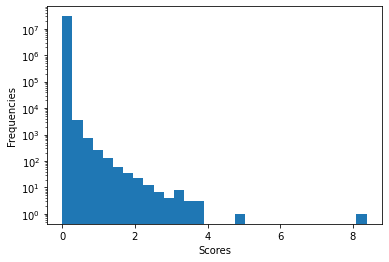

In [23]:
_=plt.hist(score_matrix.fillna(0).values.flatten(),bins=30,log=True)
plt.xlabel("Scores")
plt.ylabel("Frequencies")

In [24]:
import numpy as np
np.quantile(score_matrix.fillna(0).values.flatten(),0.99)

0.02062822850204057

Text(32.99999999999999, 0.5, 'TGs')

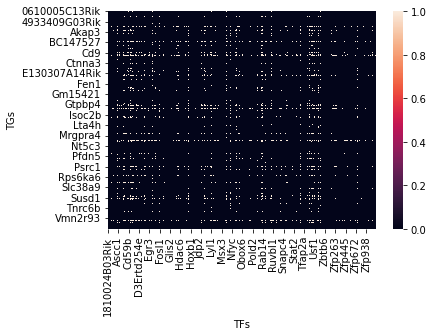

In [37]:
sns.heatmap(score_matrix>=0.01)
plt.xlabel("TFs")
plt.ylabel("TGs")

# Derive potential regulomes from these co-expression modules

In [25]:
from pyscenic.utils import modules_from_adjacencies

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [27]:
modules = list(modules_from_adjacencies(ranking, X.T))


2022-04-02 23:57:10,962 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-04-02 23:57:14,656 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-04-03 00:00:21,909 - pyscenic.utils - INFO - Creating modules.


In [13]:
with open("modules.p", 'wb') as f:
    pickle.dump(modules, f)

#with open("modules.p", 'rb') as f:
#    modules = pickle.load(f)

# Prune modules for targets with cis regulatory footprints (aka RcisTarget)
using the [motif annotation file](https://resources.aertslab.org/cistarget/motif2tf/)

In [14]:
from pyscenic.prune import prune2df, df2regulons

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [15]:
df = prune2df(dbs, modules, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2022-04-03 08:48:47,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Gtf2h3 could be mapped to mm9-tss-cente


2022-04-03 08:53:00,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Rfc2 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:53:00,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Rfc3 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:53:02,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Rfxank could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:53:10,782 - pyscenic.transform - WARNING - Less than 80% of the genes in Cbfa2t2 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:53:12,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Rps6ka5 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:53:13,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Ccnt2 could be mapped to mm9-tss-centered-5k


2022-04-03 08:55:17,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp410 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:55:17,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp414 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:55:17,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp438 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:55:17,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp442 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:55:18,987 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp451 could be mapped to mm9-tss-centered-5kb-10species.mc8nr. Skipping this module.

2022-04-03 08:55:19,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp454 could be mapped to mm9-tss-centered

In [16]:
df.head()

Enrichment                                  \
                                     AUC       NES MotifSimilarityQvalue   
TF    MotifID                                                              
Arnt  cisbp__M4597              0.047483  3.203049              0.000799   
Arntl cisbp__M4500              0.049997  3.054491              0.000220   
Atf2  transfac_pro__M01186      0.044710  3.327723              0.000428   
      cisbp__M4307              0.043907  3.084520              0.000042   
      transfac_public__M00040   0.045240  3.488033              0.000000   

                                                   \
                              OrthologousIdentity   
TF    MotifID                                       
Arnt  cisbp__M4597                       1.000000   
Arntl cisbp__M4500                       0.984026   
Atf2  transfac_pro__M01186               1.000000   
      cisbp__M4307                       1.000000   
      transfac_public__M00040            1.000000   

                                                                                  \
                                                                      Annotation   
TF    MotifID                                                                      
Arnt  cisbp__M4597             gene is annotated for similar motif transfac_p...   
Arntl cisbp__M4500             motif similar to cisbp__M5290 ('ARNTL2[gene ID...   
Atf2  transfac_pro__M01186     motif similar to cisbp__M0300 ('Atf2[gene ID: ...   
      cisbp__M4307             gene is annotated for similar motif cisbp__M03...   
      transfac_public__M00040                         gene is directly annotated   

                                                                                  \
                                                                         Context   
TF    MotifID                                                                      
Arnt  cisbp__M4597             (activating, mm9-tss-centered-5kb-10species.mc...   
Arntl cisbp__M4500             (activating, mm9-tss-centered-5kb-10species.mc...   
Atf2  transfac_pro__M01186     (activating, mm9-tss-centered-5kb-10species.mc...   
      cisbp__M4307             (activating, mm9-tss-centered-5kb-10species.mc...   
      transfac_public__M00040  (activating, mm9-tss-centered-5kb-10species.mc...   

                                                                                  \
                                                                     TargetGenes   
TF    MotifID                                                                      
Arnt  cisbp__M4597             [(Ube2b, 0.0009816805855371031), (Braf, 0.0030...   
Arntl cisbp__M4500             [(Ube2b, 0.005186591283543599), (Picalm, 0.002...   
Atf2  transfac_pro__M01186     [(Lrrtm2, 0.0038032888604838644), (Braf, 0.021...   
      cisbp__M4307             [(Tead1, 0.000690824205305947), (Traf4, 0.0015...   
      transfac_public__M00040  [(Klf9, 0.06767447735150797), (Per3, 0.0015902...   

                                         
                              RankAtMax  
TF    MotifID                            
Arnt  cisbp__M4597                 1456  
Arntl cisbp__M4500                  770  
Atf2  transfac_pro__M01186          713  
      cisbp__M4307                  759  
      transfac_public__M00040       827

In [17]:
df.to_csv("motifs.csv")

+ This dataframe can then be converted to regulons.

In [18]:
regulons = df2regulons(df)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [19]:
with open("regulons.p", 'wb') as f:
    pickle.dump(regulons, f)

#with open("regulons.p", 'rb') as f:
#    regulons = pickle.load(f)

# Cellular regulon enrichment matrix (aka AUCell)

Characterize the different cells in a single-cell transcriptomics experiment by the enrichment of the regulons. Enrichment of a regulon is measures as AUC of the recovery curve of the genes that define this regulon.

In [23]:
from pyscenic.aucell import aucell

In [35]:
auc_mtx = aucell(ex_matrix.T, regulons, num_workers=1)

100%|█████████████████████████████████████████| 263/263 [00:10<00:00, 25.23it/s]


/Users/sergiopeignier/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


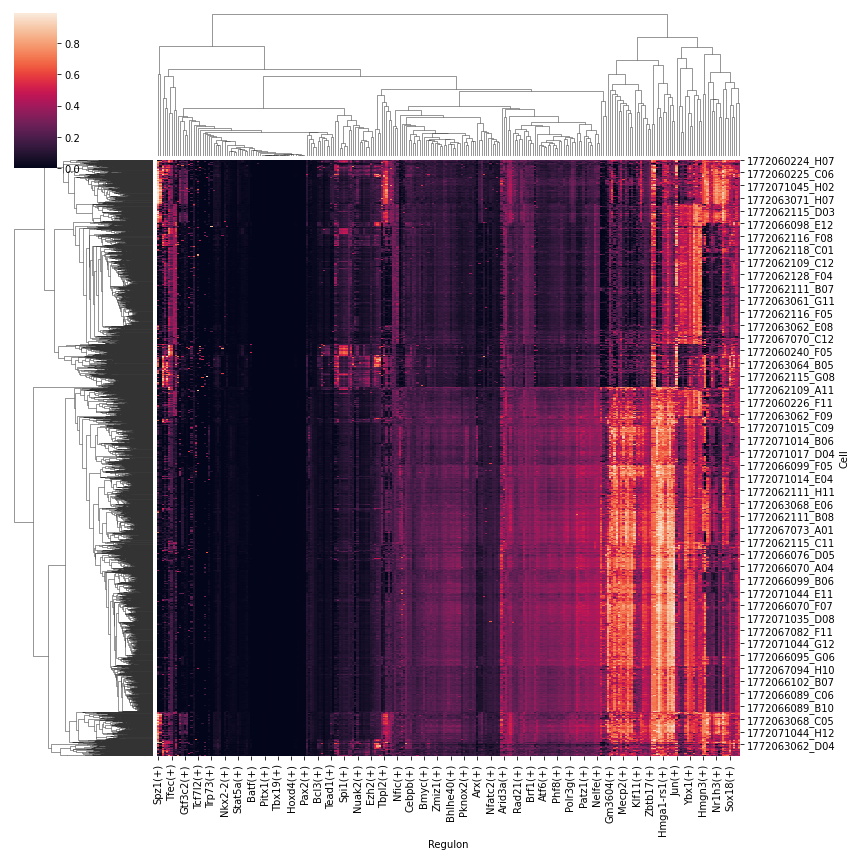

In [36]:
sns.clustermap(auc_mtx, figsize=(12,12))